In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
from covariance_generation import generate_galactocentric_covmat, transform_cov_cylindirical
from mcmc_plots import *
import data_analysis
import transformation_constants
from velocity_curve_plots import load_bin_settings
import helper_functions as helpfunc
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd
import pickle


In [3]:
def load_galactic_parameters():
   
   # Initial Galactocentric distance
   r_0 = 8277

   # Initial height over Galactic plane
   z_0 = 25

   # Initial solar vector
   v_sun = transformation_constants.V_SUN
   v_sun[0][0] = 11.1
   v_sun[1][0] = 251.5
   v_sun[2][0] = 8.59
   
   return r_0, z_0, v_sun

def apply_initial_cut(icrs_data, run_out_path):

   r_0, z_0, v_sun = load_galactic_parameters()

   galcen_data = data_analysis.get_transformed_data(icrs_data,
                                          include_cylindrical = True,
                                          z_0 = z_0,
                                          r_0 = r_0,
                                          v_sun = v_sun,
                                          debug = True,
                                          is_bayes = True,
                                          is_source_included = True)

   C_icrs = covariance_generation.generate_covmat(icrs_data, is_parallax=True)


   data_array_ICRS =  icrs_data[["ra", "dec","r_est","pmra","pmdec","radial_velocity"]].to_numpy()
   galactocentric_cov = covariance_generation.transform_cov_matrix(C = C_icrs, 
                                        df = data_array_ICRS,
                                        coordinate_system = 'Cartesian',
                                        z_0 = z_0,
                                        r_0 = r_0,
                                        is_bayes = True)

   data_array_crt = galcen_data[["x", "y","r","phi","v_r","v_phi"]].to_numpy()
   cyl_cov = transform_cov_cylindirical(data_array_crt, 
                                                C = galactocentric_cov,
                                                Z_0 = z_0,
                                                R_0 = r_0)
   galcen_data = galcen_data.merge(cyl_cov, on='source_id')

   # Final data cut
   galcen_data = galcen_data[(galcen_data.r < 15000) & (galcen_data.r > 5000)]
   galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]
   galcen_data.reset_index(inplace=True, drop=True)
   
   return galcen_data

In [5]:
print('Importing necessary column names...')
icrs_data_columns = pd.read_csv("/local/sven/gaia_tools_data/gaia_rv_data_bayes.csv", nrows = 10).columns


print('Importing DR3...')
dr3_path = '/local/mariacst/2022_v0_project/data/GaiaDR3_RV_RGB_fidelity.csv'
gaia_dr3 = pd.read_csv(dr3_path)
icrs_data = gaia_dr3[icrs_data_columns]
print("Initial size of sample: {}".format(icrs_data.shape))

Importing necessary column names...
Importing DR3...
Initial size of sample: (6586329, 24)


In [6]:
r_0, z_0, v_sun = load_galactic_parameters()

galcen_data = data_analysis.get_transformed_data(icrs_data,
                                        include_cylindrical = True,
                                        z_0 = z_0,
                                        r_0 = r_0,
                                        v_sun = v_sun,
                                        debug = True,
                                        is_bayes = True,
                                        is_source_included = True)

C_icrs = covariance_generation.generate_covmat(icrs_data, is_parallax=True)


data_array_ICRS =  icrs_data[["ra", "dec","r_est","pmra","pmdec","radial_velocity"]].to_numpy()
galactocentric_cov = covariance_generation.transform_cov_matrix(C = C_icrs, 
                                    df = data_array_ICRS,
                                    coordinate_system = 'Cartesian',
                                    z_0 = z_0,
                                    r_0 = r_0,
                                    is_bayes = True)


Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 8.822393856942654 sec


In [7]:
cyl_cov = covariance_generation.transform_cov_cylindirical(
                                galcen_data, 
                                galactocentric_cov,
                                Z_0 = transformation_constants.Z_0,
                                R_0 = transformation_constants.R_0)

In [8]:
galcen_data = galcen_data.merge(cyl_cov, on='source_id')

# Final data cut
galcen_data = galcen_data[(galcen_data.r < 15000) & (galcen_data.r > 5000)]
galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]
galcen_data.reset_index(inplace=True, drop=True)

In [10]:
galcen_data.shape

(1694972, 13)

In [11]:
# Fitting R0, New Binning, 100% Data - GPU
path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-01-09-21-42-37_48_full_run'

paths=[path1]
labels =[]

samplers=[]
for folder_path in paths:\
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')

# Load run settings and print
bin_setup = load_bin_settings(path1, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 12500. 13500. 14500.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        13000., 14000., 15000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (1694972, 14)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 16345131.071153244), (6500.0, 15324108.947150422), (7500.0, 16477548.613107478), (8500.0, 17032245.1478021), (9500.0, 17707337.81653618), (10500.0, 18367241.28037138), (11500.0, 16910304.40112109), (12500.0, 16233734.62908763), (13500.0, 19241182.2

In [12]:
# Gets V_c mean values and errors
burnin = 3000
path = samplers[0]
reader = emcee.backends.HDFBackend(path, read_only=True)
samples_data = reader.get_chain(discard=burnin)
flatchain = reader.get_chain(flat=True, discard = burnin)

bin_velocities = []
ndim = samples_data.shape[2]

for i in range(ndim):
    mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
    bin_velocities.append((v_mean, v_sub, v_sup))
velocity_array = np.array(bin_velocities)

In [13]:
r_min = 5000/8277
r_max = 15000/8277

# Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                        theta = 8277,
                                                        BL_r_min = r_min,
                                                        BL_r_max = r_max,
                                                        BL_z_min = -200,
                                                        BL_z_max = 200,
                                                        N_bins = (10, 1),
                                                        r_drift = True,
                                                        debug = False)


In [14]:
weighted_mean_velocities = []
weighted_var_velocities = []

# Bootstrap errors
for i, bin in enumerate(bin_collection.bins):

    bin.bootstrapped_error = helpfunc.bootstrap_weighted_error(bin.data.v_phi.to_numpy(), bin.data.sig_vphi.to_numpy())

    bin_vphi = bin.data.v_phi.to_numpy()
    bin_sig_vphi = bin.data.sig_vphi.to_numpy()

    weights = 1/bin_sig_vphi
    
    # Weighted mean
    weighted_mean = np.average(bin_vphi, weights=weights)

    weighted_mean_velocities.append(weighted_mean)
    weighted_var_velocities.append(bin.bootstrapped_error)


In [ ]:
# Note Needed - OBSOLETE

A_array = []
for i, bin in enumerate(bin_collection.bins):
    bin.A_parameter = bin.compute_A_parameter(h_r = 3000, 
                                            h_sig = 21000, 
                                            debug=False)
    print(bin.r_boundaries)
    print(bin.A_parameter)
    A_array.append(bin.A_parameter)




In [21]:
# Compute va error #1 - OBSOLETE
r, A = zip(*bin_setup['A_r_info'])
A = np.array(A_array)

va_error_array = []

for i,bin in enumerate(bin_collection.bins):
    v_c = velocity_array[:,0][0:-2][i]
    v_phi = weighted_mean_velocities[i]
    A_i = 2*A[i]

    # add the sub and sup and divide by 2
    vc_error = ((velocity_array[:,1][0:-2][i] + velocity_array[:,2][0:-2][i])/2)
    vphi_error = weighted_var_velocities[i]
    print("vc_error: {}".format(vc_error))
    print("vphi_error: {}".format(np.sqrt(vphi_error)))

    add_1 = -A_i*(v_c + v_phi)**(-2)*vc_error
    add_2 = -A_i*(v_c + v_phi)**(-2)*np.sqrt(vphi_error)

    va_error = np.sqrt(add_1**2 + add_2**2)
    print(va_error)

    va_error_array.append(va_error)

va_error_array = np.array(va_error_array)
va_error_array

vc_error: 4.1735100781562835
vphi_error: 0.3591546954535026
0.0691604016724854
vc_error: 4.305315469665501
vphi_error: 0.31843674576260395
0.06322330889672627
vc_error: 4.369257537075171
vphi_error: 0.40253341726855163
0.0675296827440209
vc_error: 4.366526564713567
vphi_error: 0.4615921682743534
0.07053666795063801
vc_error: 4.398296194863818
vphi_error: 0.3347122773828321
0.07640810995222592
vc_error: 4.194607912990591
vphi_error: 0.3448961850171731
0.07698631619804724
vc_error: 4.298913417338753
vphi_error: 0.3842972340184024
0.07634865271119608
vc_error: 4.128333378666184
vphi_error: 0.48595432840255026
0.07279147355870431
vc_error: 3.9910157359184666
vphi_error: 0.6148868282239125
0.08812560250899364
vc_error: 3.910312257516466
vphi_error: 1.0875013690492918
0.10896360547416137


array([0.0691604 , 0.06322331, 0.06752968, 0.07053667, 0.07640811,
       0.07698632, 0.07634865, 0.07279147, 0.0881256 , 0.10896361])

In [15]:
# Compute va error #2 - NEW

va_error_array = []

for i,bin in enumerate(bin_collection.bins):
    v_c = velocity_array[:,0][0:-2][i]
    v_phi = weighted_mean_velocities[i]

    # add the sub and sup and divide by 2
    vc_error = ((velocity_array[:,1][0:-2][i] + velocity_array[:,2][0:-2][i])/2)
    vphi_error = weighted_var_velocities[i]
    print("vc_error: {}".format(vc_error))
    print("vphi_error: {}".format(np.sqrt(vphi_error)))

    va_error = np.sqrt(vc_error**2 + vphi_error**2)
    print(va_error)

    va_error_array.append(va_error)

va_error_array = np.array(va_error_array)
va_error_array

vc_error: 4.195186938361374
vphi_error: 0.36019621602321966
4.197192663717743
vc_error: 4.320078265252704
vphi_error: 0.30499326118681747
4.321079622474906
vc_error: 4.39239024838291
vphi_error: 0.39983077677740586
4.395298488206186
vc_error: 4.382997242364695
vphi_error: 0.4645147804520874
4.388305280807688
vc_error: 4.41992728262025
vphi_error: 0.3451341784335394
4.421532108505843
vc_error: 4.204987324076001
vphi_error: 0.3292793275162881
4.206384950200522
vc_error: 4.313579359471646
vphi_error: 0.37641985013931206
4.315905870845613
vc_error: 4.15200402279811
vphi_error: 0.48583174399837914
4.158707580317204
vc_error: 4.012571741020494
vphi_error: 0.6414078831550093
4.033606982313251
vc_error: 3.955629362314383
vphi_error: 1.099531898864939
4.136255924373023


array([4.19719266, 4.32107962, 4.39529849, 4.38830528, 4.42153211,
       4.20638495, 4.31590587, 4.15870758, 4.03360698, 4.13625592])

(array([ 6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

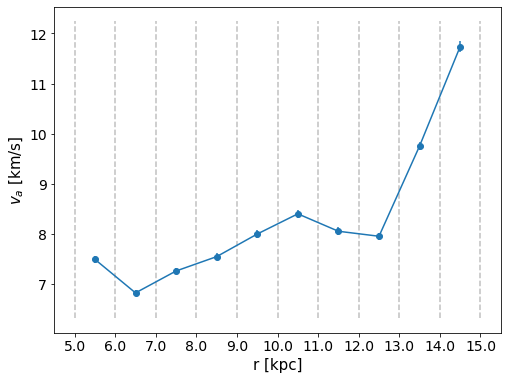

In [22]:
r, A = zip(*bin_setup['A_r_info'])

fig, ax = plt.subplots(figsize=(8, 6))

x = r
y = -2*np.array(A_array)/(velocity_array[:,0][0:-3] + weighted_mean_velocities)

ax.scatter(x, y)

plt.errorbar(x, y, 
                    yerr=va_error_array)

# plt.errorbar(x_values, -y_values,
#                     yerr= y_error,
#                     fmt='o', c=colors[i_path], label=labels[i_path])

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)

bin_edges_r = bin_setup['bin_edges'][0][0]
bin_edges_z = bin_setup['bin_edges'][1].T[0]

ax.vlines(bin_edges_r, np.min(y) - 0.5, np.max(y) + 0.5, linestyles='dashed', alpha=0.5, colors='grey')
ax.set_xticks(bin_edges_r)

fontdict = {'fontsize' : 15}

ax.set_xlabel('r [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$v_a$ [km/s]', fontdict= fontdict)

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Asymmetric Drift Velocity', fontsize=18, pad=12)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

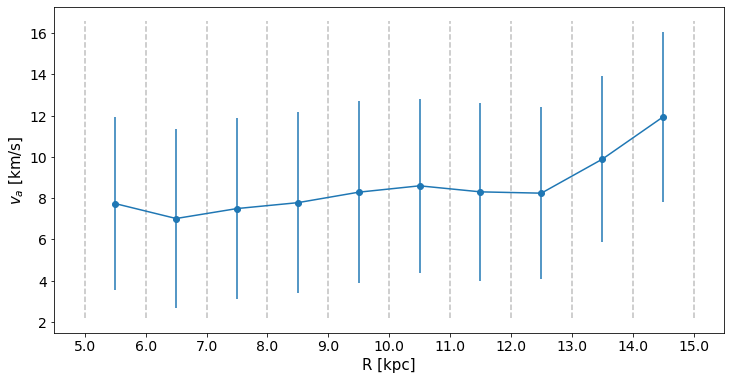

In [12]:
r, A = zip(*bin_setup['A_r_info'])

fig, ax = plt.subplots(figsize=(12, 6))

x = r
y = velocity_array[:,0][0:-3] - weighted_mean_velocities

ax.scatter(x, -y)

plt.errorbar(x, -y, 
                    yerr=va_error_array)

# plt.errorbar(x_values, -y_values,
#                     yerr= y_error,
#                     fmt='o', c=colors[i_path], label=labels[i_path])

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)

bin_edges_r = bin_setup['bin_edges'][0][0]
bin_edges_z = bin_setup['bin_edges'][1].T[0]



ax.vlines(bin_edges_r, np.min(-(y + va_error_array)) - 0.5, np.max(-(y - va_error_array)) + 0.5, linestyles='dashed', alpha=0.5, colors='grey')
ax.set_xticks(bin_edges_r)

fontdict = {'fontsize' : 15}

ax.set_xlabel('R [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$v_a$ [km/s]', fontdict= fontdict)

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Asymmetric Drift Velocity', fontsize=18, pad=12)

#plt.savefig('Asm_Drift.png', dpi = 300, bbox_inches='tight')

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

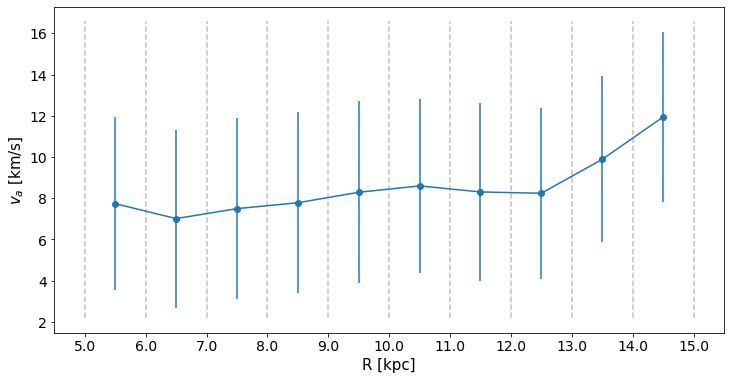

In [16]:
r, A = zip(*bin_setup['A_r_info'])

fig, ax = plt.subplots(figsize=(12, 6))

x = r
y = velocity_array[:,0][0:-3] - weighted_mean_velocities

ax.scatter(x, -y)

plt.errorbar(x, -y, 
                    yerr=va_error_array)

# plt.errorbar(x_values, -y_values,
#                     yerr= y_error,
#                     fmt='o', c=colors[i_path], label=labels[i_path])

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)

bin_edges_r = bin_setup['bin_edges'][0][0]
bin_edges_z = bin_setup['bin_edges'][1].T[0]



ax.vlines(bin_edges_r, np.min(-(y + va_error_array)) - 0.5, np.max(-(y - va_error_array)) + 0.5, linestyles='dashed', alpha=0.5, colors='grey')
ax.set_xticks(bin_edges_r)

fontdict = {'fontsize' : 15}

ax.set_xlabel('R [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$v_a$ [km/s]', fontdict= fontdict)

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.title('Asymmetric Drift Velocity', fontsize=18, pad=12)

#plt.savefig('Asm_Drift.png', dpi = 300, bbox_inches='tight')

In [21]:
np.round(-y,1)

array([ 7.7,  7. ,  7.5,  7.8,  8.3,  8.6,  8.3,  8.2,  9.9, 11.9])

In [22]:
np.round(va_error_array, 1)

array([4.2, 4.3, 4.4, 4.4, 4.4, 4.2, 4.3, 4.2, 4. , 4.1])

In [15]:
weighted_mean_velocities = np.array(weighted_mean_velocities)
weighted_var_velocities = np.array(weighted_var_velocities)
r_array = np.array(r)

In [29]:
data_array = np.vstack((r_array, weighted_mean_velocities, weighted_var_velocities))
data_array.T

array([[ 5.50000000e+03, -2.23259169e+02,  1.31411919e-01],
       [ 6.50000000e+03, -2.29734737e+02,  9.81012801e-02],
       [ 7.50000000e+03, -2.32395857e+02,  1.58081018e-01],
       [ 8.50000000e+03, -2.31243153e+02,  2.16960449e-01],
       [ 9.50000000e+03, -2.26940680e+02,  1.17224601e-01],
       [ 1.05000000e+04, -2.25512332e+02,  1.10818350e-01],
       [ 1.15000000e+04, -2.23679947e+02,  1.53632658e-01],
       [ 1.25000000e+04, -2.23182236e+02,  2.37071268e-01],
       [ 1.35000000e+04, -2.18682221e+02,  3.84685506e-01],
       [ 1.45000000e+04, -2.12719768e+02,  1.17155029e+00]])

In [31]:

        

df = pd.DataFrame(data_array.T, columns = ['r','v_phi_wght_mean','boot_error'])
df.to_csv('full_run_rot_vel.csv', index=False)
df



,r,v_phi_wght_mean,boot_error
0,5500.0,-223.259169,0.131412
1,6500.0,-229.734737,0.098101
2,7500.0,-232.395857,0.158081
3,8500.0,-231.243153,0.216960
4,9500.0,-226.940680,0.117225
5,10500.0,-225.512332,0.110818
6,11500.0,-223.679947,0.153633
7,12500.0,-223.182236,0.237071
8,13500.0,-218.682221,0.384686
9,14500.0,-212.719768,1.171550


# Linear Regression of Velocity Curve

In [58]:
from scipy.stats import linregress
linear_reg_result = linregress(np.array(r)/1e3, np.abs(velocity_array[0:-3][:,0]))
linear_reg_result

LinregressResult(slope=-1.0839689676875655, intercept=244.10231456946138, rvalue=-0.6960565801597061, pvalue=0.02536930124195945, stderr=0.39531550927817977)

In [59]:
linear_reg_result[0]*8.277 + linear_reg_result[1]

235.1303034239114

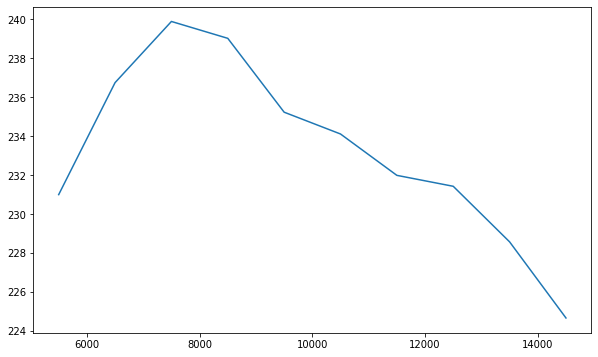

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(r, np.abs(velocity_array[0:-3][:,0]))